<font size=4 color=darkblue>目標</font>

本次作業是想要驗證以下 3 點而進行的實驗

- 完整資料及主成分資料的準確率與執行時間比較
- 介紹多元羅吉斯回歸、支援向量機、神經網路的參數選擇
- 多元羅吉斯回歸、支援向量機、神經網路的比較
---

【台北大學碩士班課程】淺度機器學習<br>
【授課老師】汪群超<br>
【學期】1112 <br>
【主要內容】分類器的原理與評比實驗：多元羅吉斯回歸、支援向量機、神經網路<br>
【作者】711133117 陳怡升 <br>
【參考網站】
- 老師講義：[汪群超 Shallow Machine Lesson 8: 淺度機器學習：分類器的原理與評比實驗](https://ntpuccw.blog/sml-lesson-8-%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9a%e5%88%86%e9%a1%9e%e5%99%a8%e7%9a%84%e5%8e%9f%e7%90%86%e8%88%87%e8%a9%95%e6%af%94%e5%af%a6%e9%a9%97/)
- 多元羅吉斯回歸：[Sklean LogisticRegression 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

- SVM
    - [SVM: Feature Selection and Kernels](https://towardsdatascience.com/svm-feature-selection-and-kernels-840781cc1a6c)
    - [SVM 支援向量機演算法-原理篇](https://iter01.com/582104.html)
    - [Sklean SVC 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

- 神經網路
    - [深度神經網路](https://medium.com/@afly.bsky/dnn-%E6%B7%B1%E5%BA%A6%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-cf892cbb06d5)
    - [Sklean MLPClassifier 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
    
- Cross Validation
    - [Day 5 / 必備實作知識與工具 / 關於 Training，還有一些基本功（一）](https://ithelp.ithome.com.tw/articles/10240556)
    - [Sklean GridSearchCV 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2, glob, time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [2]:
file = r'C:\Course\1112ShallowMachineLearning\data'

In [2]:
file = r'D:\711133117\1112ShallowMachineLearning\data'

定義蒙太奇，資料探算可以看一下圖片的樣子

In [3]:
def montage(A, m, n, sz):
    if type(A)==pd.core.frame.DataFrame:
        A = np.array(A)
    M = np.zeros((m*sz[0], n*sz[1])) # montage image
    for i in range(0,m):
        for j in range(0,n):
            M[i*sz[0]:(i+1)*sz[0], j*sz[1]:(j+1)*sz[1]] = A[i*n+j,:].reshape(sz[0], sz[1])
    return M

# 資料探索

In [4]:
import scipy.io
D = scipy.io.loadmat(file + r'\allFaces.mat')
X = pd.DataFrame(D['faces'].T) # each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = int(D['m'])
n = int(D['n'])
n_persons = int(D['person'])

查看每個人第一筆資料

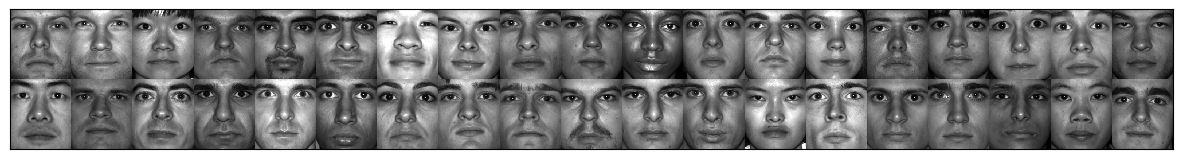

In [5]:
sz = np.array((192, 168)) 
plt.figure(figsize=(15,15))
M = montage(X.loc[np.pad(y.cumsum()[:-1],(1,0)),:], 19, 2, sz[::-1]).T
plt.imshow(M, cmap=plt.cm.gray , interpolation='nearest')
plt.xticks ([]), plt.yticks ([])
plt.show()

# 資料設定，切分 Train 和 Test
在評比各個學習器之前要先介紹訓練資料以及測試資料的差別。機器學習中，會需要學習資料的規則並且進行預測，若將所有資料全部拿來訓練再進行預測，就有點像考試全部都出考古題，連數字都沒改，此時測試出來的準確度就有失公正。因此通常會將完整資料分為訓練資料（Training Data）與測試資料（Test Data），兩者之間不可以有任何的重疊，利用訓練資料來訓練，測試資料來測試模型的準確度。

在此將訓練及測試資料切分為 75 : 25，後續會使用 CrossValidation 的方式進行參數選擇。

## 原始資料（有標準化）

In [6]:
X = pd.DataFrame(D['faces'].T)
y = np.repeat(range(0,len(D['nfaces'][0])), repeats=D['nfaces'][0])

In [7]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

## 主成分資料

下圖為主成分的解釋能力圖，發現取 319 個主成分，解釋程度有達到 99 %，因此取 319 個主成分。

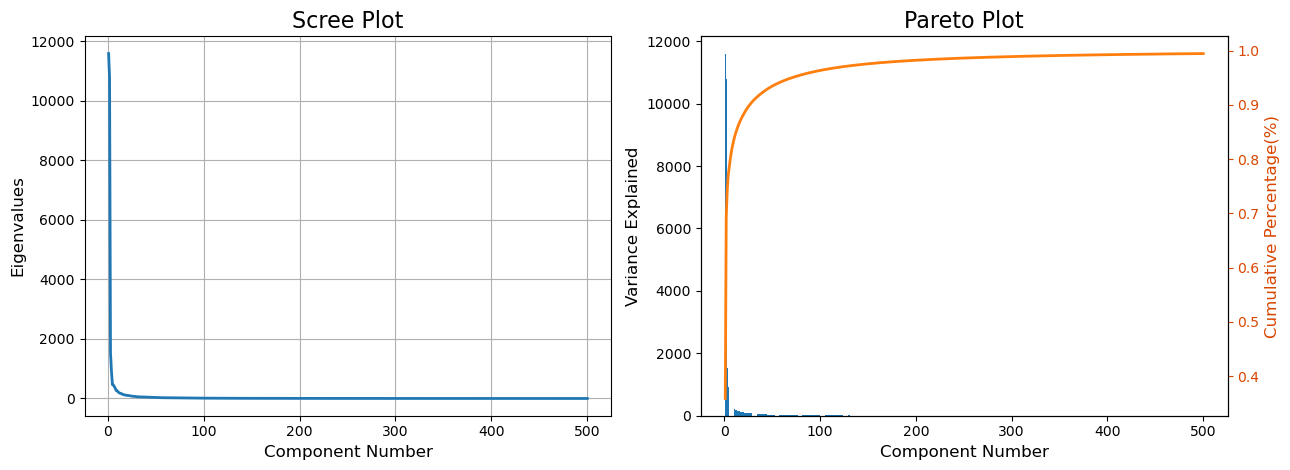

CPU times: total: 33.4 s
Wall time: 5.13 s


In [27]:
%%time

pca = PCA(n_components=500).fit(X_train_)

fig, axes = plt.subplots(ncols=2, figsize=(13,4.8))
x = np.arange(1,1+len(pca.explained_variance_))
axes[0].plot(x, pca.explained_variance_, lw=2)
# axes[0].set_xticks(x)
axes[0].set_xlabel('Component Number', fontsize=12)
axes[0].set_ylabel('Eigenvalues', fontsize=12)
axes[0].grid(True)
axes[0].set_title('Scree Plot', fontsize=16)

axes[1].bar(x, pca.explained_variance_)
ax2 = axes[1].twinx()
ax2.plot(x, pca.explained_variance_ratio_.cumsum(), color='C1', lw=2)
ax2.tick_params(axis='y', colors='#D94600')
ax2.set_ylabel('Cumulative Percentage(%)', fontsize=12, color="#D94600")
axes[1].set_xlabel('Component Number', fontsize=12)
axes[1].set_ylabel('Variance Explained', fontsize=12)
axes[1].set_title('Pareto Plot', fontsize=16)

plt.tight_layout()
plt.show()

In [28]:
ratio = 0.99
print("取 {} 個變數，解釋程度有達到 {} %".format(sum(pca.explained_variance_ratio_.cumsum() < ratio)+1, ratio))
n_comp = sum(pca.explained_variance_ratio_.cumsum() < ratio)+1

取 319 個變數，解釋程度有達到 0.99 %


In [29]:
%%time

pca = PCA(n_components = n_comp).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)

CPU times: total: 23.4 s
Wall time: 3.34 s


# 比較資料之間的表現

以羅吉斯為例，對 2 種資料進行訓練及預測，紀錄測試資料的準確率及訓練時間。

<font size=4> **混淆矩陣** </font>

在介紹評判標準之前，要先讓讀者了解到混淆矩陣。混淆矩陣是呈現實際結果與預測結果的矩陣，如下所示：

||預測 YES|預測 NO|
|----------|:-------------:|------:|
|實際 YES|TP|FN|
|實際 NO|FP|TN|

從混淆矩陣可以延伸出許多指標，像是準確率（Accuracy）、精確率（precision）和召回率（recall）、F-score 等。

<font size=4> **評判標準** </font>

在此說明本文使用到的評判標準，分別有準確率、F-score 及運算時間。

- 準確率（accuracy）：預測的正確率，公式如下
    \begin{equation}
    ACC = \frac{TP+TN}{P+N} = \frac{TP+TN}{TP+TN+FP+FN}
    \end{equation}
    
- F-score：除了正確率以外，同時考量到精確率及召回率的部分，讓每個類別的準確率都有被考量到。計算公式如下

    \begin{equation}
    F_1 = \frac{2\times precision\times recall}{precision+recall} = \frac{2TP}{2TP+FP+FN}
    \end{equation}
    
    在 sklearn 中不同的計算方式：
    
    - binary : 只適用於二類別的 Y。
    - micro : 通過計算 TP、FN 和 FP 的總數來計算指標。
    - macro : 每個類別分別計算指標，之後直接將各類別平均為最後的結果。缺點是沒有考慮標籤不平衡。
    - weighted : 每個類別分別計算指標，並按照每個類別的真實筆數計算加權平均值。比「macro」宏觀更能處理不平衡資料，但可能導致 F1Score 不介於精確率（precision）和召回率（recall）之間。
    
    由於我們資料是平衡資料，**因此直接使用 macro 進行計算**。

- 運算時間：呈現方式為 hh:mm:ss ，這邊紀錄的是配適及預測時間，並不包含評分的時間。

## 原始資料有標準化

In [35]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = X_train_;test = X_test_
df_want = pd.DataFrame()

start_time = time.time()
logistic_org = LogisticRegression(solver = 'lbfgs', **opts)
logistic_org.fit(train, y_train)
y_pred = logistic_org.predict(test)
end_time = time.time()
# 紀錄要用的資訊
tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
      'f1score':[f1_score(y_test, y_pred, average='weighted')], 
      'time':[(end_time - start_time)], 'data':['原始資料（有標準化）'],
      'solver':['lbfgs']})
df_want = pd.concat([df_want, tmpdf], ignore_index=True)

## 319 個主成分資料

In [37]:
opts = dict(tol = 0.000001, max_iter = int(1e6))

train = Z_train; test =Z_test

start_time = time.time()
logistic_org = LogisticRegression(solver = 'lbfgs', **opts)
logistic_org.fit(train, y_train)
y_pred = logistic_org.predict(test)
end_time = time.time()
# 紀錄要用的資訊
tmpdf = pd.DataFrame(data = {'Method':['Logistic'], 'accuracy':[accuracy_score(y_test, y_pred)], 
      'f1score':[f1_score(y_test, y_pred, average='weighted')], 
      'time':[(end_time - start_time)], 'data':[f'{n_comp} 個主成分'],
      'solver':[solver]})
df_want = pd.concat([df_want, tmpdf], ignore_index=True)

In [44]:
df_want['time(hh:mm:ss)'] = [time.strftime("%H:%M:%S", time.gmtime(i)) for i in df_want['time']]

## <font color=darkred>比較結果</font>

由下方表格可知，表格中的 `time(hh:mm:ss)` 為執行的時間。可以發現在準確率與 f1 score 差不多的情況下 **主成分資料所需要的時間比原始資料少許多**，因此後續分類器的參數設定及比較都使用主成分資料來進行。

In [45]:
df_want

,Method,accuracy,f1score,time,data,solver,time(hh:mm:ss)
0,Logistic,0.955224,0.954792,660.229174,原始資料（有標準化）,lbfgs,00:11:00
1,Logistic,0.953566,0.953042,11.680760,319 個主成分,lbfgs,00:00:11


# 分類器參數設定

本節旨在找到各分類器最佳的參數設定，會將訓練資料（整體資料的 80\%）進行交叉驗證，利用準確率及 f1score 找出最好的參數。

<font size=4> **CrossValidation** </font>

k 折交叉驗證（k-fold cross-validation），將訓練資料切割成 k 份資料，保留 1 份作為驗證模型的資料，將其餘 k-1 份用來訓練模型，進行 k 次交叉驗證，讓每份資料都有機會驗證一次，其運作方式如下圖所示。 <br>


<div>
<img src="https://i.imgur.com/SoH3X9z.png" width="500"/>
</div>


<font size=4> **評判標準** </font>

與第三節比較資料之間的表現相同。

【使用程式】

- `StratifiedShuffleSplit` : 切割資料，設定 random_state 固定切割的方式才能比較！

- `GridSearchCV` : 執行所有參數，並找出最佳參數
## 多元羅吉斯迴歸

**<font size=4>參數調整</font>**

多元羅吉斯迴歸在 sklearn 套件中的指令為 `sklearn.linear_model`，指令為 `LogisticRegression`。有不同的演算法（`solver`）可以調整，可以選擇 lbfgs、liblinear、newton-cg、sag、saga，預設為 lbfgs。

- liblinear 適合小的資料集，而 sag 和 saga 適合大型資料，因為運算時間更快

- 針對多類別的反應變數，只有 newton-cg、sag、saga、lbfgs，可以計算 multinomial loss

- liblinear 是 one-versus-rest 的方法

各演算法可以使用的懲罰項：
- lbfgs : l2, None
- liblinear : l1, l2
- newton-cg : l2, None
- sag : l2, None
- saga : elasticnet, l1, l2, None

In [61]:
opts = dict(tol = 0.000001, max_iter = int(1e6))
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg','sag','saga']}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(LogisticRegression(tol=0.000001, max_iter=int(1e6)), param_grid=parameters, cv=cv, 
                    scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)
df_want_logistic = pd.DataFrame(data = grid.cv_results_)

In [62]:
df_want_logistic['fit_time(hh:mm:ss)'] = [time.strftime("%H:%M:%S", time.gmtime(i)) for i in df_want_logistic['mean_fit_time']]
df_want_logistic['score_time(hh:mm:ss)'] = [time.strftime("%H:%M:%S", time.gmtime(i)) for i in df_want_logistic['mean_score_time']]

In [63]:
df_want_logistic.loc[:,['param_solver', 'mean_test_accuracy', 'mean_test_f1_macro','fit_time(hh:mm:ss)','score_time(hh:mm:ss)']]

,param_solver,mean_test_accuracy,mean_test_f1_macro,fit_time(hh:mm:ss),score_time(hh:mm:ss)
0,lbfgs,0.949724,0.949386,00:00:19,00:00:00
1,liblinear,0.974586,0.974847,00:00:13,00:00:00
2,newton-cg,0.949171,0.948746,00:00:12,00:00:00
3,sag,0.941436,0.941309,00:49:04,00:00:00
4,saga,0.941989,0.941889,01:50:18,00:00:00


## 支援向量機（Support Vector Machine，SVM）

SVM是一種用於分類和回歸分析的機器學習算法。在分類問題中，SVM嘗試在找到兩類數據點之間最佳分離超平面（hyperplane），以二維來說超平面就是一條線，以三維來說超平面就是一個面，如下圖所示。

<div>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*FwrX8viaCLljRAAxiSAp8Q.png" width="600"/>
</div>

至於怎麼找出 hyperplane 可以參考 [SVM 支援向量機演算法-原理篇](https://iter01.com/582104.html)。

**<font size=4>參數調整</font>**

SVM 在 sklearn 套件中的指令為 `sklearn.svm`，在此我們使用到之中的 `SVC`，也就是應用在分類問題的 SVM。下方列出 `SVC` 中重要的調整參數及它們的意義。

- `C` : 懲罰係數，就是對誤差的容忍度，預設為 1。<br>
    C 越高，越不能接受誤差，容易過度配適（Overfitting），反之，C越小，接受的誤差太大，就會發生配適不足（Underfitting）的情況。


- `kernel` : 核函式，linear、poly、rbf、sigmoid，預測為 rbf。<br>
    kernel 就是上述文章提到的**核函式**，可以將樣本從低維空間對映到高維空間，讓 SVM 可以處理非線性問題，是 SVM 中的核心角色。其中每個核函式皆會有不同的參數需要調整，SVM 的參數選擇看起來很多，但其實是因為每個核函式要調整參數不同，接著介紹核函式及需要調整的參數。

    - linear : 線性函式
       
    - sigmoid : S 型內核，主要調整參數有 gamma、C。
    
    - poly : 多項函式，主要調整參數有 degree、gamma、C。

    - rbf : rbf (Radial Based Function) 徑向核函數可以表示無限多維空間，主要調整參數有 degree、gamma、C。
        
        
- `degree` : 調整多項式的最高次方，預設為 3，只有在 `kernel='ploy'` 時會用到。


- `gamma` : 單筆資料的影響範圍，scale、auto、非負小數，預設為 scale，只有在核函數是非線性函式會用到，像是：poly、rbf、sigmoid。<br>
    **低代表遠，高則代表近**，因此 gamma 越小，計算 hyperplane 考量到的支援向量就越多，反之。
    
    - scale : $\frac{1}{nfeatures \times X.var()}$
    
    - auto : $\frac{1}{nfeatures}$


- `decision_function_shape` : 決策函數，ovr 或 ovo，預設為 ovr。
    
    - ovr : one-vs-rest，每個群組在建立 hyperplane 時是以其他全部群組作為對立面，可以不用運算那麼多次，但就會是不平衡資料。
    
    - ovo : one-vs-one，每個群組在建立 hyperplane 時是以其他個別群組作為對立面，要運算較多次。

In [70]:
def boxplotset(xcol, ycol, df_want):
    draw_dict = {}
    for i in np.sort(list(set(df_want[xcol]))):
        draw_dict[i] = df_want.loc[df_want[xcol]==i, ycol]
    plt.boxplot([i for i in draw_dict.values()], labels=[str(i) for i in draw_dict.keys()])
    plt.ylabel(ycol)
    plt.xlabel(xcol)
    plt.show()

### 決策函數

In [68]:
C_range = [1, 10, 100, 1000]
gamma_range = np.logspace(-4, 1, 6)
parameters = {'decision_function_shape':('ovr','ovo'), 'C':C_range, 'gamma':gamma_range}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(SVC(tol=0.000001, max_iter=int(1e6)), param_grid=parameters, cv=cv, 
                    scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)
df_want = pd.DataFrame(data = grid.cv_results_)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.0001} with a score of 0.87


<font size=4 color=darkred>【決策函數選擇】</font>

`mean_fit_time` 是配適時間，以秒為單位，紅酒資料中的類別只有 3 類，並沒有太多類別，而且資料筆數少，所以執行時間上並不會有太大的差距。因此選擇哪種決策函數都可！

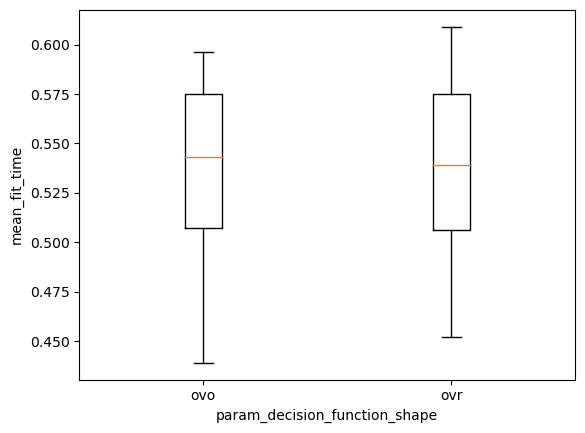

In [71]:
boxplotset('param_decision_function_shape', 'mean_fit_time', df_want)

### 其他參數

In [64]:
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [1, 10]

parameters = [{'kernel': ['linear'], 'C':C_range}, 
              {'kernel': ['rbf', 'sigmoid'], 'gamma':gamma_range, 'C':C_range},
              {'kernel': ['poly'], 'gamma':gamma_range, 'C':C_range, 'degree':[2,3,4,5,6]}]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(SVC(tol=0.000001, max_iter=int(1e6)), param_grid=parameters, cv=cv, 
                    scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)

df_want_SVM = pd.DataFrame(data = grid.cv_results_)
print("The best parameters are %s with an accuracy of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.01, 'kernel': 'linear'} with an accuracy of 0.94


In [65]:
df_want_SVM['fit_time(hh:mm:ss)'] = [time.strftime("%H:%M:%S", time.gmtime(i)) for i in df_want_SVM['mean_fit_time']]
df_want_SVM['score_time(hh:mm:ss)'] = [time.strftime("%H:%M:%S", time.gmtime(i)) for i in df_want_SVM['mean_score_time']]

In [ ]:
col = ['params', 'mean_test_accuracy', 'mean_test_f1_macro', 'mean_fit_time', 'mean_score_time']
df_want_SVM.loc[df_want_SVM['mean_test_f1_macro']==df_want_SVM['mean_test_f1_macro'].max(), col]

In [ ]:
df_want_SVM.loc[df_want_SVM['mean_test_accuracy']==df_want_SVM['mean_test_accuracy'].max(), col]

<font size=4 color=darkred>【參數選擇結果】</font>

從上述可知，最佳參數為使用線性核函數以及 0.1 的懲罰係數，有高達 97\% 的正確率及 0.97 的 f1score。但在不同參數組合之下，都會影響準確率的好壞，因此，利用 `GridSearchCV` 對所有參數進行驗證，挑出最好的，作為後續模型比較的參考！

## 神經網路（Neural Network，NN）
類神經網路是用類似神經傳導的方式來尋找資料的規律，以視覺為例，其傳導路徑為眼睛看到物體 → 視網膜（刺激光感受器細胞） → 視神經（傳導至大腦） → 大腦（判斷看到的物體），而類神經網路的執行方式與此相似。典型的類神經網路具有以下三個部分：
1. 輸入端（Input）<br>
    輸入端為一開始輸入的資料，像是眼睛看到物體的步驟，輸入的資料可以不只一個，下圖中的黃色部分即為輸入端。
    
2. 隱藏層（Hidden Layer）<br>
    隱藏層為中間的處理過程，通常隱藏層會使用數學函式進行轉換或判斷，像是視網膜的刺激、視神經的傳導以及大腦判斷，隱藏層可以有一層以上，1圖中藍色及綠色部分即為隱藏層。
    
3. 輸出層（Output Layter）<br>
    輸出層就是最後判斷的結果，像是大腦判斷看見的物體是手機，輸出層也可以有多個，下圖中的粉紅色部分即為輸出層。

![image-2.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*6AxEGdJGViO8oF-YPXkQag.png)

**<font size=4>參數調整</font>**

神經網路在 sklearn 套件中的指令為 `sklearn.neural_network`，我們使用到指令 `MLPClassifier`，也就是應用在分類問題的神經網路。下方列出重要的調整參數及意義。

- `activation` : 激活函數，可選擇 identity, logistic, tanh, relu，預設為 relu。<br>
    激活函數最主要的目的就是在神經網路中加入非線性的部分，詳細函數的型態請參考下圖。
    
    <div>
<img src="https://1394217531-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvBP1svpACTB1R1x_U4%2F-LvNWUoWieQqaGmU_gl9%2F-LvO3qs2RImYjpBE8vln%2Factivation-functions3.jpg?alt=media&token=f96a3007-5888-43c3-a256-2dafadd5df7c" width="500"/>
</div>

- `solver` : 權重優化的演算法，可選擇 lbfgs, sgd, adam，預設為 adam。<br>
    - lbfgs :  family of quasi-Newton methods
    - sgd : refers to stochastic gradient descent
    - adam : refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

- `hidden_layer_sizes` : (神經元的個數, 隱藏層層數)，設定模型的複雜度，看要有幾個和幾層神經元。<br>
    要特別注意的是 Sklearn 的隱藏層不包含輸出層，預設為(100,)，也就是只有一層100 個神經元的隱藏層。

In [74]:
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
activ_range = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']


parameters = {'activation': activ_range, 'solver':solver, 
               'hidden_layer_sizes':[(i,) for i in np.arange(40, 141, 20)]}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
grid = GridSearchCV(MLPClassifier(tol=0.000001, max_iter=int(1e8)), param_grid=parameters, cv=cv, 
                    scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(train, y_train)

df_want_NN = pd.DataFrame(data = grid.cv_results_)
df_want_NN['nodes'] = [i[0] for i in df_want_NN['param_hidden_layer_sizes']]

In [ ]:
print("The best parameters are %s with an accuracy of %0.2f" % (grid.best_params_, grid.best_score_))

In [ ]:
df_want_NN.loc[df_want_NN['mean_test_f1_macro']==df_want_NN['mean_test_f1_macro'].max(),['params', 'mean_test_accuracy', 'mean_test_f1_macro']]

In [ ]:
df_want_NN.loc[df_want_NN['mean_test_accuracy']==df_want_NN['mean_test_accuracy'].max(),['params', 'mean_test_accuracy', 'mean_test_f1_macro']]

<font size=4 color=darkred>【參數選擇結果】</font>


從上述可知，最佳參數為：使用 35 個神經元、relu 激活函式、adam 演算法，有高達 98\% 的正確率及 0.98 的 f1score。

由下兩張圖可以觀察到不同神經元個數在不同激活函式及演算法下的表現狀況，可以明顯觀察出以下幾點：

- 神經元個數等於 35 明顯優於其他
- 在 35 個神經元時，激活函數 relu 有最佳的表現，但沒有 tanh 穩定。
- 在 35 個神經元時，演算法 adam 有最佳的表現，但沒有 sgd 穩定。

但在不同參數組合之下，都會影響準確率的好壞，因此，利用 `GridSearchCV` 對所有參數進行驗證，挑出最好的，作為後續模型比較的參考！

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_want_NN, x='nodes', y='mean_test_accuracy', hue='param_activation')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_want_NN, x='nodes', y='mean_test_accuracy', hue='param_solver')
plt.show()

# 不同資料之間與不同分類器的比較

分別將 3 種資料帶入 3 種不同的分類器進行比較。

- 3 種資料：無標準化的原始資料、標準化的原始資料及主成分資料
- 3 種分類器：多元羅吉斯迴歸、支援向量機（SVM）、神經網路（NN）

In [ ]:
for data in ['沒有標準化', '原始資料標準化', 'PCA']:
    if data == '沒有標準化':
        train = X_train; test =X_test
    elif data == '原始資料標準化':
        train = X_train_; test =X_test_
    else :
        

In [ ]:
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)